## Import required libraries.

In [1]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120) 
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Setup input data 
Define spatial resolution: Specify the resolution of the input DEM and also the desired working resolution (can be same as input DEM resolution).

In [190]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\junk')
os.chdir(location)
input_geotiff = gdal.Open('bogie_sub_1m.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / working_resolution, order = 1)

input_outlets = gdal.Open('test_out_3.tif')
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = 1 - o

## Visualise the DEM.

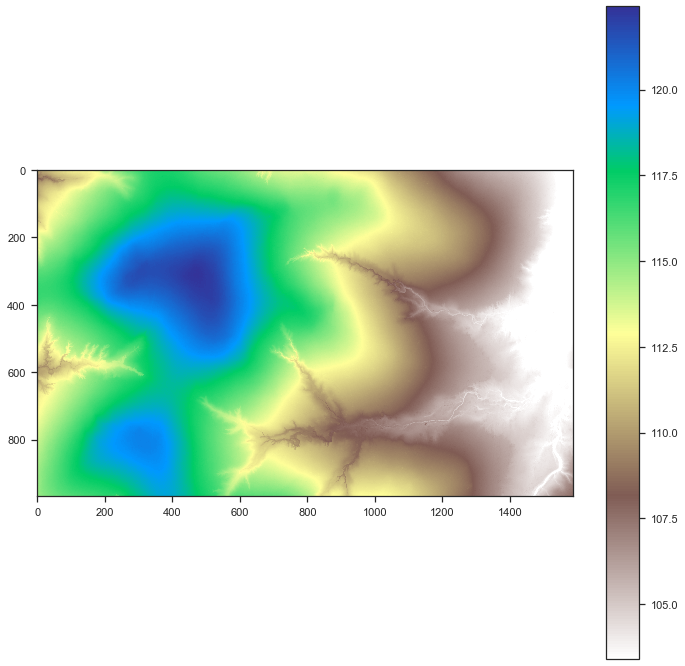

In [191]:
plt.figure(figsize=(12,12))
plt.imshow(input_DEM, cmap="terrain_r", vmin = np.percentile(input_DEM, 5));
plt.colorbar();

## Define required function.

In [192]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def flow_dir_dataset(flow_rec_prop, catchment_area, grid_resolution, outlet_node):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction.
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.        
    The resulting Dataset is used to calculate specific catchment area."""
    array_direction = xr.Dataset()
    for i in range(0,8):
        rows = catchment_area.shape[0]; cols = catchment_area.shape[1];
        direction = np.flip(flow_rec_prop[:,i].reshape(rows,cols), 0);
        # Above needs to be flipped because during reshape it organises data top down
        # rather than bottom up as per ModelGrid order (catchment_area is mg arrangement).
        zero_outlet = outlet_node != 1
        remove_outlet = zero_outlet * catchment_area
        weighted_direction = xr.DataArray((remove_outlet * direction),
                                          dims = ['lat', 'lon']);
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def closest(lst, K): 
     angle_list = lst
     idx = (np.abs(angle_list - K)).argmin() 
     return angle_list[idx]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range

## Setup a RasterModelGrid object and assign elevation to nodes.

In [193]:
catchment_area_grids = xr.Dataset()
direction_list = ['East', 'North', 'West', 'South',
                  'North East', 'North West', 'South West', 'South East'];
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

## Find the node ID of the outlet.
Note: Outlet spatial location is given by the 'outlets' variable assigned under "Setup input data."

In [194]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_outlet_ids = grid_nodes * outlets
outlet_id = np.unique(find_outlet_ids)[1]
outlet_id

1113789

## Fill sinks and run flow accumulation.

In [195]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step()

## Show a list of values located on each node.

In [196]:
mg.at_node.keys()

['topographic__elevation',
 'sediment_fill__depth',
 'water__unit_flux_in',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'flow__receiver_proportions',
 'topographic__steepest_slope',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag']

## Assign some of the above values to variables.

In [197]:
da = np.array(mg.at_node['drainage_area'].round(4));
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node'];
drainage_area = np.flip(da.reshape(mg.shape), 0);
wuf = np.array(mg.at_node['water__unit_flux_in']);
frp = np.array(mg.at_node['flow__receiver_proportions']);
funo = np.array(mg.at_node['flow__upstream_node_order'].reshape(mg.shape));
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0);
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
flrn = mg.at_node['flow__link_to_receiver_node'];
links_carrying_flow = flrn.reshape(flow_rec_surf_rows,8);
tss = mg.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);
flow_dir_da = flow_dir_dataset(all_receiver_proportions, drainage_area, 1, ns);
catchment_area_grids['flow_direction_grids' + '1' + '1'] = flow_dir_da;

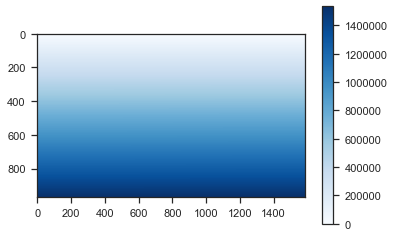

In [198]:
plt.imshow(grid_nodes, cmap="Blues");
plt.colorbar();

For each flow direction (given by the second index position of the flow__receiver_node object) find the rows (where each row is a single grid cell) that are contributing to a target grid cell. The target grid cell in the first instance will be the outlet node, and then the list of target grid cells will expand with every processing step.

In [199]:
start = timeit.default_timer()
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
distance_from_outlet = 20
# This value is used to initialise the search.
catchment_outlet_id = outlet_id
# Initate an outer loop that iterates through every distance interval from the outlet.
watershed_grid_cells = []
node_location = mg.nodes.reshape(da.shape)
ordered_node_list = []

for i in range(0, distance_from_outlet):
    # Create a list initially containing only the outlet grid cell.
    if i == 0:
        candidate_gridcells = [catchment_outlet_id];
    else:
        candidate_gridcells = list(set(upstream_nodes));
    # Empty the list of upsteam nodes.
    upstream_nodes = {};
    # Intiate a new loop to check every gridcell at the current interval distance.
    print(candidate_gridcells)
    for grid_cell in candidate_gridcells:
        # Check each flow direction of the current grid cell.The second dimension of the 
        # flow__receiver_node object will always be size == 8.
        for i in range(frn.shape[1]):
            # Return all rows (grid nodes) that send any flow to the target grid cell.
            # Note: This can only be one grid cell because the prgram is looping through
            # each direction one at a time so only one grid cell can be sending flow from any
            # one given direction.
            flow_from_whole_grid_cell = frn[np.where(frn[:,i] == grid_cell)];
            # Check if the current direction contributes flow. If not, do nothing. 
            # Else, append to list.
            if flow_from_whole_grid_cell.shape[0] == 0:
                pass
            else:
                # Below variable finds the row position of the flow_from_direction gridcell
                # in the flow__receiver_node array. This corresponds to the contributing
                # cell's node id.
                node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                #Find the proportion of flow leaving the donor node and heading toward 
                # the current grid cell.
                proportion_of_flow = frp[node_id_value, i]
                # Create a boolean array to use as mask on drainage area.
                isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                node_directional_drainage_area = node_drainage_area * proportion_of_flow
                upstream_nodes.update({node_id_value:node_directional_drainage_area});
        if len(upstream_nodes) == 0:
            print ("dictionary empty")
        else:
            primary_flow_direction_id = max(upstream_nodes.items(), key=operator.itemgetter(1))[0]
            upstream_nodes = []
            upstream_nodes.append(primary_flow_direction_id);
            ordered_node_list.append(primary_flow_direction_id);
            watershed_grid_cells.append(primary_flow_direction_id)
                    
stop=timeit.default_timer()
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

[1113789]
[1112202]
[1110614]
[1109026]
[1107438]
[1105850]
[1104261]
[1104262]
[1102675]
[1101086]
[1099499]
[1097911]
[1096323]
[1094734]
[1093147]
[1091559]
[1089971]
[1089970]
[1088381]
[1086792]
Time taken =  7.196626399998422 seconds


In [200]:
preliminary_width = np.isin(node_location,watershed_grid_cells)
flow_width = (preliminary_width * da).reshape(mg.shape)

In [201]:
flow_width[flow_width==0] = np.nan

In [202]:
flow_grid_nodes = (preliminary_width * da).reshape(mg.shape)

In [203]:
len(ordered_node_list)

20

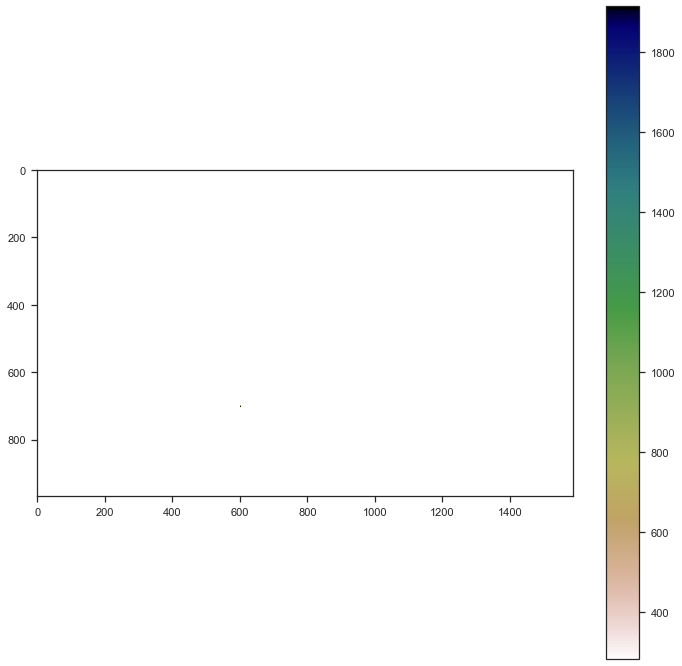

In [204]:
plt.figure(figsize=(12,12))
plt.imshow(flow_width, cmap="gist_earth_r");
plt.colorbar();

In [205]:
drainage_mask = flow_width > 0

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [206]:
radius = 9
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))
dfme = generic_filter(input_DEM, difference_from_mean_elevation, 
                        footprint= circleWindow(radius), mode='nearest');
dfme[dfme > 5.0] = 5.0
dfme[dfme < -5.0] = -5.0

In [207]:
radius = 9
central_value = find_median_value(circleWindow(radius));
num_values = number_of_values(circleWindow(radius));
pctl = generic_filter(input_DEM, PCTL, footprint= circleWindow(radius), mode='nearest');

In [208]:
slope = generic_filter(input_DEM, slopeWindowDegrees,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

In [209]:
profile_curvature = generic_filter(input_DEM, profileCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (input_DEM_resolution,));
profile_curvature[profile_curvature > 0.1] = 0.1
profile_curvature[profile_curvature < -0.1] = -0.1

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


## Mask out all grid cells that do not exist along the drainage line. 

In [210]:
drainage_slope = np.copy(slope).astype('float32')
drainage_slope[~drainage_mask] = np.nan

In [211]:
drainage_profile_curvature = np.copy(profile_curvature).astype('float32')
drainage_profile_curvature[~drainage_mask] = np.nan

In [212]:
drainage_dfme = np.copy(dfme).astype('float32')
drainage_dfme[~drainage_mask] = np.nan

In [213]:
drainage_area = np.copy(catchment_area_ha).astype('float32')
drainage_area[~drainage_mask] = np.nan

In [214]:
drainage_pctl = np.copy(pctl).astype('float32')
drainage_pctl[~drainage_mask] = np.nan

In [215]:
drainage_nodes = np.copy(grid_nodes).astype('float32')
drainage_nodes[~drainage_mask] = np.nan

Flatten everything out into 1D arrays so that values can be matched up as in cells below.

In [216]:
lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
drainage_dfme_1d = np.squeeze(drainage_dfme.reshape(1, lat * lon))
drainage_slope_1d = np.squeeze(drainage_slope.reshape(1, lat * lon))
drainage_pc_1d = np.squeeze(drainage_profile_curvature.reshape(1, lat * lon))
drainage_area_1d = np.squeeze(drainage_area.reshape(1, lat * lon))
drainage_pctl_1d = np.squeeze(drainage_pctl.reshape(1, lat * lon))

In [217]:
node_drainage_dfme_dict = {}
for A, B in zip(nodes_1d, drainage_dfme_1d):
    node_drainage_dfme_dict[A] = B
    
dfme_from_gully_unordered = { key:value for key, value in node_drainage_dfme_dict.items() if ~np.isnan(value)}

# This just reorders the dictionary to reflect the actual node order along the flow line.
# The step above creates a dictionary where the keys are ordered from highest to lowest and this is not always
# going to reflect the node order (only if the flow line is moving south to north).
dfme_from_gully = {k: dfme_from_gully_unordered[k] for k in ordered_node_list}

In [218]:
node_drainage_pc_dict = {}
for A, B in zip(nodes_1d, drainage_pc_1d):
    node_drainage_pc_dict[A] = B

pc_from_gully_unordered = { key:value for key, value in node_drainage_pc_dict.items() if ~np.isnan(value) }
pc_from_gully = {k: pc_from_gully_unordered[k] for k in ordered_node_list}

In [219]:
node_drainage_slope_dict = {}
for A, B in zip(nodes_1d, drainage_slope_1d):
    node_drainage_slope_dict[A] = B

slope_from_gully_unordered = { key:value for key, value in node_drainage_slope_dict.items() if ~np.isnan(value) }
slope_from_gully = {k: slope_from_gully_unordered[k] for k in ordered_node_list}

In [220]:
node_drainage_area_dict = {}
for A, B in zip(nodes_1d, drainage_area_1d):
    node_drainage_area_dict[A] = B

area_from_gully_unordered = { key:value for key, value in node_drainage_area_dict.items() if ~np.isnan(value) }
area_from_gully = {k: area_from_gully_unordered[k] for k in ordered_node_list}

In [221]:
node_drainage_pctl_dict = {}
for A, B in zip(nodes_1d, drainage_pctl_1d):
    node_drainage_pctl_dict[A] = B

pctl_from_gully_unordered = { key:value for key, value in node_drainage_pctl_dict.items() if ~np.isnan(value) }
pctl_from_gully = {k: pctl_from_gully_unordered[k] for k in ordered_node_list}

In [222]:
ds = [dfme_from_gully, pc_from_gully, slope_from_gully, area_from_gully, pctl_from_gully]
d = {}
for k in dfme_from_gully.keys():
    d[k] = tuple(d[k] for d in ds)
d_ordered = {k: d[k] for k in ordered_node_list}

In [223]:
# Need to somehow replace node id with 0-n early on and then add the node list to the pandas array after.

In [224]:
drainage_parameters = pd.DataFrame.from_dict(d_ordered)

In [225]:
drainage_parameters.rename(index={0:'DFME',1:'PC', 2: 'Slope', 3: 'Area', 4: 'PCTL'}, inplace=True)

In [226]:
drainage_parameters_transpose = drainage_parameters.T

In [227]:
drainage_parameters_transpose.insert(0, "Distance", 0);

for i in range(0, distance_from_outlet):
    drainage_parameters_transpose.iloc[i,0] = i

In [228]:
drainage_parameters_transpose['Node ID'] = drainage_parameters_transpose.index

## Find the angle theta between CP and GH. 

        First find width of the array in the second dimension so that I can find the distance between the GH and CP by minusing the node values from each other. I think I should take the absolute value of this because all I need is H and L to find theta and it doesn't actally matter what the direction is. However, maybe by preserving direction it will hold potentially some seful information. So maybe use the scheme of negative or positive and explain why this is done instead of just taking the absolute value.

### First determine if it is north or south flowing.
Extract gully head and convergence point and subtract gully head from convergence point. Gully head is subtracted from convergence point because that returns negative values putting in place a convention that if water is flowing from south to north (opposite) the value will be negative, but if it flows for north to south (normal) it will be positive. 

In [229]:
algorithm_end_point = drainage_parameters_transpose['Distance'].max()
algorithm_start_point = drainage_parameters_transpose['Distance'].min()

### Gully head

In [230]:
gh = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_end_point,
                                                  'Node ID'].values[0]

### Convergence point

In [231]:
cp = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_start_point,
                                                  'Node ID'].values[0]

### Distance between convergence point and gully head

In [232]:
node_length = np.abs(cp - gh)
length = node_length/mg.shape[0]

## Find orientation

First isolate the graph quadrant the gully head is in. This uses the convention that the convergence point is always at the origin of a coordinate system.

Always subtract gully head from convergence point for latitude (so that values are positive above the x-axis).

Always subtract convergence point from gully head for longitude (so that values are positive to the right of the y-axis).

This keeps the system consistent with a standard 2D Cartesian plane.

Latitude = CP-GH; index position == 0

Longitude = GH - CP; index position == 1 

Quadrant 1 - upper left: CP-GH (+), GH-CP (-)  

Quadrant 2 - upper right:  CP-GH (+), GH-CP (+)  

Quadrant 3 - lower left:  CP-GH (-), GH-CP (-)  

Quadrant 4 - lower right:  CP-GH (-), GH-CP (+)  

In [233]:
gh_lat = np.where(grid_nodes == gh)[0][0]
cp_lat = np.where(grid_nodes == cp)[0][0]
gh_lon = np.where(grid_nodes == gh)[1][0]
cp_lon = np.where(grid_nodes == cp)[1][0]

lat_displacement = cp_lat - gh_lat
lon_displacement = gh_lon - cp_lon

### Encode the minimum angle value of the quadrant. Quadrants follow convention for quadrants of a unit circle

In [234]:
if lat_displacement > 0 and lon_displacement > 0:
    angle_max = 90
    angle_min = 0
    quadrant = 1
    print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
elif lat_displacement > 0 and lon_displacement < 0:
    angle_max = 360
    angle_min = 270
    quadrant = 2
    print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
elif lat_displacement < 0 and lon_displacement < 0:
    angle_max = 270
    angle_min = 180
    quadrant = 3
    print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
else:
    angle_max = 180
    angle_min = 90
    quadrant = 4
    print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))

Quadrant = Q2 min angle 270 max angle 360


In [235]:
theta_a = np.degrees(np.arctan(np.abs(lat_displacement)/np.abs(lon_displacement)))

In [236]:
theta_a

79.380344723844871

## Now impose a an alternating combination of theta A and the minimum or maximum angle of the quadrant.

In [237]:
if quadrant == 1:
    gully_orientation = angle_max - theta_a
elif quadrant == 2:
    gully_orientation = angle_min + theta_a
elif quadrant == 3:
    gully_orientation = angle_max - theta_a
else:
    gully_orientation = angle_min + theta_a

In [238]:
gully_orientation

349.38034472384487

## Create a list of possible angles and find which is closest to the gully orientation.

In [239]:
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
            
        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
            
        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes


Instantiate a GullyOrientation class object using the previous determined gully_orientation, the outlet_id and the shape of the ModelGrid object.

In [240]:
gully_and_cross_section = GullyOrientation(gully_orientation, outlet_id, mg.shape)

In [241]:
line_length = 30

In [242]:
cross_section_nodes = gully_and_cross_section.cross_section(line_length)

north-south gully


In [243]:
gully_and_cross_section.closest_angle

360

Create a boolean mask from the cross section.

In [244]:
cross_section_nodes.shape

(61,)

In [245]:
cross_section_mask = np.isin(node_location,cross_section_nodes).reshape(mg.shape)

Create a variable that can be written to tiff to visualise. 

In [246]:
cross_section_image = cross_section_mask.astype('uint8')

Use boolean mask to extractsurface derivatives along cross section.

In [247]:
cross_section_slope = np.copy(slope).astype('float32')
cross_section_slope[~cross_section_mask] = np.nan

In [248]:
cross_section_profile_curvature = np.copy(profile_curvature).astype('float32')
cross_section_profile_curvature[~cross_section_mask] = np.nan

In [249]:
cross_section_dfme = np.copy(dfme).astype('float32')
cross_section_dfme[~cross_section_mask] = np.nan

In [250]:
cross_section_area = np.copy(catchment_area_ha).astype('float32')
cross_section_area[~cross_section_mask] = np.nan

In [251]:
cross_section_pctl = np.copy(pctl).astype('float32')
cross_section_pctl[~cross_section_mask] = np.nan

In [252]:
cross_section_nodes = np.copy(grid_nodes).astype('float32')
cross_section_nodes[~cross_section_mask] = np.nan

In [253]:
cross_section_elevation_prep = np.copy(input_DEM).astype('float32')
cross_section_elevation_prep[~cross_section_mask] = np.nan
cross_section_elevation = cross_section_elevation_prep - np.nanmin(cross_section_elevation_prep)

In [254]:
cross_section_dfme_line = cross_section_elevation_prep - np.nanmean(cross_section_elevation_prep)

In [255]:
lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
cross_section_slope_1d = np.squeeze(cross_section_slope.reshape(1, lat * lon))
cross_section_pc_1d = np.squeeze(cross_section_profile_curvature.reshape(1, lat * lon))
cross_section_area_1d = np.squeeze(cross_section_area.reshape(1, lat * lon))
cross_section_pctl_1d = np.squeeze(cross_section_pctl.reshape(1, lat * lon))
cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
cross_section_dfme_line_1d = np.squeeze(cross_section_dfme_line.reshape(1, lat * lon))


In [256]:
node_cross_section_dfme_dict = {}
for A, B in zip(nodes_1d, cross_section_dfme_1d):
    node_cross_section_dfme_dict[A] = B
    
dfme_cross_section_unordered = { key:value for key, value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }


In [257]:
node_cross_section_pc_dict = {}
for A, B in zip(nodes_1d, cross_section_pc_1d):
    node_cross_section_pc_dict[A] = B

pc_cross_section_unordered = { key:value for key, value in node_cross_section_pc_dict.items() if ~np.isnan(value) }


In [258]:
node_cross_section_slope_dict = {}
for A, B in zip(nodes_1d, cross_section_slope_1d):
    node_cross_section_slope_dict[A] = B

slope_cross_section_unordered = { key:value for key, value in node_cross_section_slope_dict.items() if ~np.isnan(value)}


In [259]:
node_cross_section_area_dict = {}
for A, B in zip(nodes_1d, cross_section_area_1d):
    node_cross_section_area_dict[A] = B

area_cross_section_unordered = { key:value for key, value in node_cross_section_area_dict.items() if ~np.isnan(value) }


In [260]:
node_cross_section_pctl_dict = {}
for A, B in zip(nodes_1d, cross_section_pctl_1d):
    node_cross_section_pctl_dict[A] = B

pctl_cross_section_unordered = { key:value for key, value in node_cross_section_pctl_dict.items() if ~np.isnan(value) }


In [261]:
node_cross_section_elevation_dict = {}
for A, B in zip(nodes_1d, cross_section_elevation_1d):
    node_cross_section_elevation_dict[A] = B

elevation_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }


In [262]:
node_cross_section_dfme_line_dict = {}
for A, B in zip(nodes_1d, cross_section_dfme_line_1d):
    node_cross_section_dfme_line_dict[A] = B

dfme_line_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_line_dict.items() if ~np.isnan(value) }


In [263]:
ds = [dfme_cross_section_unordered, pc_cross_section_unordered, 
      slope_cross_section_unordered, area_cross_section_unordered, pctl_cross_section_unordered,
     elevation_cross_section_unordered, dfme_line_cross_section_unordered]
d = {}
for k in dfme_cross_section_unordered.keys():
    d[k] = tuple(d[k] for d in ds)


In [264]:
cross_section_parameters = pd.DataFrame.from_dict(d)

In [265]:
cross_section_parameters.rename(index={0:'DFME',1:'PC', 2: 'Slope', 
                                       3: 'Area', 4: 'PCTL', 5: 'Elevation', 6: 'DFME Line'}, inplace=True)

In [266]:
cross_section_parameters_transpose = cross_section_parameters.T

In [267]:
cross_section_parameters_transpose.insert(0, "Distance", 0)

for i in range(0, (line_length * 2)+1):
    if i < line_length:
        cross_section_parameters_transpose.iloc[i,0] = -line_length + i
    else:
        cross_section_parameters_transpose.iloc[i,0] = i - line_length
    

In [268]:
cumulative_cross_section_parameters = cross_section_parameters_transpose.cumsum()

In [269]:
cross_section_parameters_transpose['Cumulative DFME'] = cumulative_cross_section_parameters.iloc[:,1]
cross_section_parameters_transpose['Cumulative PC'] = cumulative_cross_section_parameters.iloc[:,2]
cross_section_parameters_transpose['Cumulative S'] = cumulative_cross_section_parameters.iloc[:,3]
cross_section_parameters_transpose['Cumulative A'] = cumulative_cross_section_parameters.iloc[:,4]
cross_section_parameters_transpose['Cumulative PCTL'] = cumulative_cross_section_parameters.iloc[:,5]

In [270]:
extract_slope = cross_section_parameters_transpose['Slope'].values

In [271]:
cross_section_parameters_transpose['Slope Range'] = generic_filter(extract_slope, data_range, 
                                                                       footprint= (1, 3), mode='nearest');

In [272]:
extract_dfme = cross_section_parameters_transpose['DFME'].values

In [273]:
cross_section_parameters_transpose['DFME Range'] = generic_filter(extract_dfme, data_range, 
                                                                       footprint= (1, 3), mode='nearest');

In [274]:
dCDFMEdx = np.gradient(drainage_parameters_transpose.loc[:,'DFME'].values)
d2CDFMEdx2 = np.gradient(dCDFMEdx)
 
dCPCdx = np.gradient(drainage_parameters_transpose.loc[:,'PC'].values)
d2CPCdx2 = np.gradient(dCPCdx)

dCSdx = np.gradient(drainage_parameters_transpose.loc[:,'Slope'].values)
d2CSdx2 = np.gradient(dCSdx)

dCAdx = np.gradient(drainage_parameters_transpose.loc[:,'Area'].values)
d2CAdx2 = np.gradient(dCAdx)

dPCTLdx = np.gradient(drainage_parameters_transpose.loc[:,'PCTL'].values)
d2PCTLdx2 = np.gradient(dPCTLdx)

drainage_parameters_transpose['dCDFMEdx'] = dCDFMEdx
drainage_parameters_transpose['dCPCdx'] = dCPCdx
drainage_parameters_transpose['dCSdx'] = dCSdx
drainage_parameters_transpose['dCAdx'] = dCAdx
drainage_parameters_transpose['dPCTLdx'] = dPCTLdx

drainage_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2
drainage_parameters_transpose['d2CPCdx2'] = d2CPCdx2
drainage_parameters_transpose['d2CSdx2'] = d2CSdx2
drainage_parameters_transpose['d2CAdx2'] = d2CAdx2
drainage_parameters_transpose['d2PCTLdx2'] = d2PCTLdx2

In [275]:
cumulative_drainage_parameters = drainage_parameters_transpose.cumsum()
drainage_parameters_transpose['Cumulative DFME'] = cumulative_drainage_parameters.iloc[:,1]

Text(0.5, 1.0, 'Change in upstream values for DFME and PC')

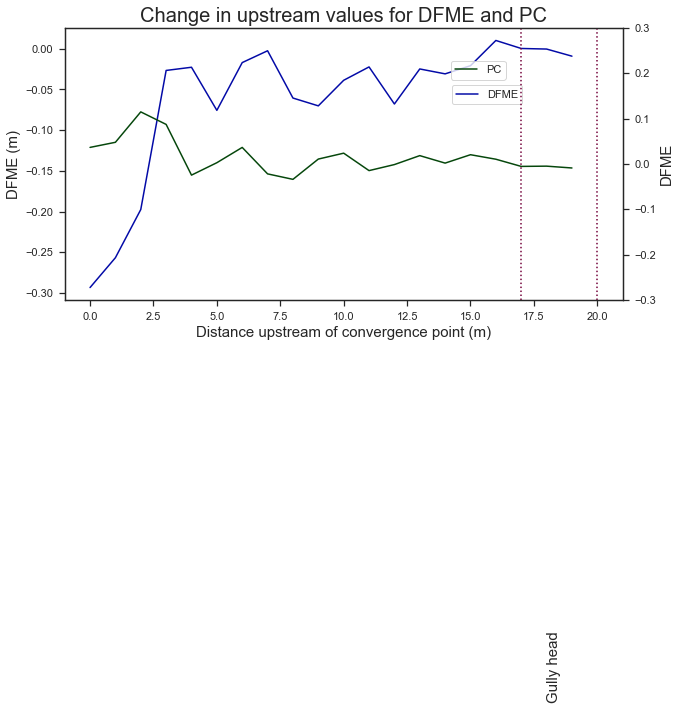

In [276]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose,x = "Distance",y = "DFME", color = 'xkcd:cobalt blue')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance upstream of convergence point (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.3, 0.21, 0.53, 0.6))
ax2 = ax1.twinx()
ax2.set_ylim(-0.3,0.3)
sns.lineplot(data=drainage_parameters_transpose,x = "Distance",y="dCDFMEdx",color='xkcd:forest green',ax = ax2)
ax2.set_ylabel('DFME', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.3, 0.5, 0.5, 0.4))
plt.axvline(x=17, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=20, color = 'xkcd:merlot', linestyle = 'dotted')
ax1.text(18, -0.8, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in upstream values for DFME and PC', fontsize = 20)

To find the endpoints of the line at the head of the gully, all i need to do is move n units in the direction of the gully orientation from the end points of the cross section line. Can use same rules from the GullOrientation class.

Note: Method below requires that the outlet_id (A) is at least 10 grid cells from the edge of the DEM. In the paper can just say gullies near edges were not used because it risks moving window values being affected.

## Scheme for finding all grid cells along the desired line.

Four possible line: 

(1) north-south, north direction == outlet_id - mg.shape[1], south direction == outlet_id + mg.shape[1]

(2) east-west, east = outlet_id + 1, west == outlet_id - 1

(3) northeast-southwest, northeast == outlet_id - (mg.shape[1] - 1), southwest == outlet_id + (mg.shape[1] - 1)

(4) northwest-southeast, northwest == outlet_id - (mg.shape[1] + 1), southeast == outlet_id + (mg.shape[1] + 1)


# Calculate the cumulative summary of each variable.

In [277]:
dCDFMEdx = np.gradient(cross_section_parameters_transpose.loc[:,'DFME'].values)
d2CDFMEdx2 = np.gradient(dCDFMEdx)
 
dCPCdx = np.gradient(cross_section_parameters_transpose.loc[:,'PC'].values)
d2CPCdx2 = np.gradient(dCPCdx)

dCSdx = np.gradient(cross_section_parameters_transpose.loc[:,'Slope'].values)
d2CSdx2 = np.gradient(dCSdx)

dCAdx = np.gradient(cross_section_parameters_transpose.loc[:,'Area'].values)
d2CAdx2 = np.gradient(dCAdx)

dPCTLdx = np.gradient(cross_section_parameters_transpose.loc[:,'PCTL'].values)
d2PCTLdx2 = np.gradient(dPCTLdx)

cross_section_parameters_transpose['dCDFMEdx'] = dCDFMEdx
cross_section_parameters_transpose['dCPCdx'] = dCPCdx
cross_section_parameters_transpose['dCSdx'] = dCSdx
cross_section_parameters_transpose['dCAdx'] = dCAdx
cross_section_parameters_transpose['dPCTLdx'] = dPCTLdx

cross_section_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2
cross_section_parameters_transpose['d2CPCdx2'] = d2CPCdx2
cross_section_parameters_transpose['d2CSdx2'] = d2CSdx2
cross_section_parameters_transpose['d2CAdx2'] = d2CAdx2
cross_section_parameters_transpose['d2PCTLdx2'] = d2PCTLdx2

In [278]:
cross_section_parameters_transpose_spline = pd.DataFrame(np.arange(-100,100)/(100.0/line_length), columns = ['Distance']) 

In [279]:
spline_smoothness = np.linspace(-line_length,line_length, 200)
spline_input_distance = cross_section_parameters_transpose.loc[:,'Distance'].values

spline_input_dfme = cross_section_parameters_transpose.loc[:,'DFME'].values
dfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
dfme_spline = dfme_spline_setup(spline_smoothness)

spline_input_dfme = cross_section_parameters_transpose.loc[:,'Cumulative DFME'].values
cdfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
cdfme_spline = cdfme_spline_setup(spline_smoothness)

spline_input_pc = cross_section_parameters_transpose.loc[:,'PC'].values
pc_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_pc)
pc_spline = pc_spline_setup(spline_smoothness)

spline_input_slope = cross_section_parameters_transpose.loc[:,'Slope'].values
slope_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope)
slope_spline = slope_spline_setup(spline_smoothness)

spline_input_slope_range = cross_section_parameters_transpose.loc[:,'Slope Range'].values
slope_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope_range)
slope_range_spline = slope_range_spline_setup(spline_smoothness)

spline_input_area = cross_section_parameters_transpose.loc[:,'Area'].values
area_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_area)
area_spline = area_spline_setup(spline_smoothness)

spline_input_dfme_range = cross_section_parameters_transpose.loc[:,'DFME Range'].values
dfme_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme_range)
dfme_range_spline = dfme_range_spline_setup(spline_smoothness)

spline_input_dfme_line = cross_section_parameters_transpose.loc[:,'DFME Line'].values
dfme_line_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme_line)
dfme_line_spline = dfme_line_spline_setup(spline_smoothness)

spline_input_elevation_range = cross_section_parameters_transpose.loc[:,'Elevation'].values
elevation_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_elevation_range)
elevation_range_spline = elevation_range_spline_setup(spline_smoothness)

spline_input_d2CDFMEdx2 = cross_section_parameters_transpose.loc[:,'d2CDFMEdx2'].values
d2CDFMEdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CDFMEdx2)
d2CDFMEdx2_spline = d2CDFMEdx2_spline_setup(spline_smoothness)

spline_input_d2CPCdx2 = cross_section_parameters_transpose.loc[:,'d2CPCdx2'].values
d2CPCdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CPCdx2)
d2CPCdx2_spline = d2CPCdx2_spline_setup(spline_smoothness)

spline_input_dCDFMEdx = cross_section_parameters_transpose.loc[:,'dCDFMEdx'].values
dCDFMEdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCDFMEdx)
dCDFMEdx_spline = dCDFMEdx_spline_setup(spline_smoothness)

spline_input_dCPCdx = cross_section_parameters_transpose.loc[:,'dCPCdx'].values
dCPCdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCPCdx)
dCPCdx_spline = dCPCdx_spline_setup(spline_smoothness)

spline_input_dCSdx = cross_section_parameters_transpose.loc[:,'dCSdx'].values
dCSdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCSdx)
dCSdx_spline = dCSdx_spline_setup(spline_smoothness)

cross_section_parameters_transpose_spline['DFMEL Spline'] = dfme_line_spline
cross_section_parameters_transpose_spline['Elevation Spline'] = elevation_range_spline
cross_section_parameters_transpose_spline['DFMER Spline'] = dfme_range_spline
cross_section_parameters_transpose_spline['DFME Spline'] = dfme_spline
cross_section_parameters_transpose_spline['Cumulative DFME Spline'] = cdfme_spline
cross_section_parameters_transpose_spline['PC Spline'] = pc_spline
cross_section_parameters_transpose_spline['A Spline'] = area_spline
cross_section_parameters_transpose_spline['Slope Spline'] = slope_spline
cross_section_parameters_transpose_spline['SR Spline'] = slope_range_spline
cross_section_parameters_transpose_spline['d2CDFMEdx2 Spline'] = d2CDFMEdx2_spline
cross_section_parameters_transpose_spline['d2CPCdx2 Spline'] = d2CPCdx2_spline
cross_section_parameters_transpose_spline['dCDFMEdx Spline'] = dCDFMEdx_spline
cross_section_parameters_transpose_spline['dCPCdx Spline'] = dCPCdx_spline
cross_section_parameters_transpose_spline['dCSdx Spline'] = dCSdx_spline

# Possible rules
1. Find peak in second derivative of DFME and then the first point it cross the x-axis.
2. Find point that PC goes from large negative to positive and then point that it crosses x-axis.
3. Some combination of 1 & 2. E.g. condition 1 only if first part of condition 2 is also met.

Probably just the first is best but can still talk about considering PC and show graph.

## Can use DFME together with one of slope, pc, area and then use a sum of squares approach to test which of the three models works best on all ~30 gullies.

# Three possible rules:

Just have set maximum distance same as flow line. For edges can be 15m in each direction. The the edge will always just be the maximum DFME or rate of change of DFME (second derivative?).

1. Find peak DFME.

2. Combination DFME and Slope Range. Just look for peak DFME followed by sections of low slope range (<5?) and DFME is within delta of the 0 line.

3. Combined DFME, PC and Slope. Look for DFME peak precded by clear - to + PC change and followed by low slope range (<5?) and DFME is within delta of the 0 line.

Increasing complexity, least squares will see if complexity is needed or not.

Then digitise edges for sample of 30 and do least squares assessment of the three methods.

# Maybe the simplest rule is to find spots where slope is low and DFME is 0.
# Or just find peak in DFME.

Text(0.5, 1.0, 'Gully cross section DFME and slope')

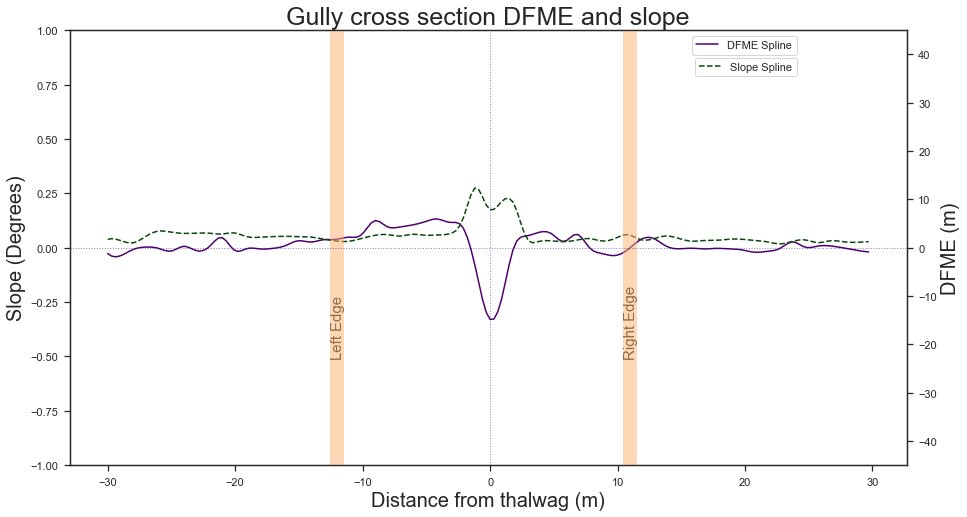

In [280]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (15, 8))
x_value = "Distance"
y1_value = "DFME Spline"
y2_value = "Slope Spline"
sns.lineplot(data = cross_section_parameters_transpose_spline, x = x_value, y = y1_value, 
             color = 'xkcd:royal purple')
ax1.set_ylabel('Slope (Degrees)', fontsize=20)
#ax1.annotate('Thalweg', arrowprops = dict(facecolor = 'black'), xy = (0, -23), xytext = (1, -29))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-1, 1)
ax1.set_xlabel('Distance from thalwag (m)', fontsize = 20)
ax1.legend([y1_value],bbox_to_anchor=(0.375, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-45, 45)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = x_value, y = y2_value
             , color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
#ax2.set_ylabel(y2_value, fontsize = 15)
ax2.set_ylabel('DFME (m)', fontsize = 20)
ax2.legend([y2_value],bbox_to_anchor=(0.375, 0.55, 0.5, 0.4))
plt.axvline(x=11, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-12, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
plt.axhline(y=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=11, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-12.5, -0.5, r'Left Edge', fontsize=15, rotation = 90)
ax1.text(10.5, -0.5, r'Right Edge', fontsize=15, rotation = 90)
plt.title('Gully cross section DFME and slope', fontsize = 25)

# 

## Second derivative works best because the highest rate is the middle of the wall going up and the point that then crosses the x-axis when the increase stops being positive (immediately after passing up over the edge of the gully) - straight from graph theory. 

## First derivative.

ValueError: Could not interpret input 'S Spline'

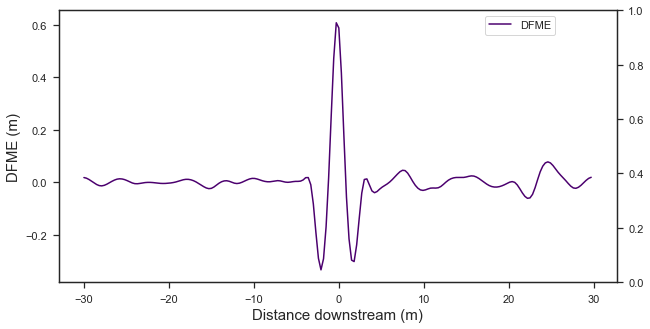

In [97]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
#ax2.set_ylim(-0.2, 0.2)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "S Spline", 
             color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=7, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(11.5, -0.075, r'Gully head', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

ValueError: Could not interpret input 'S Spline'

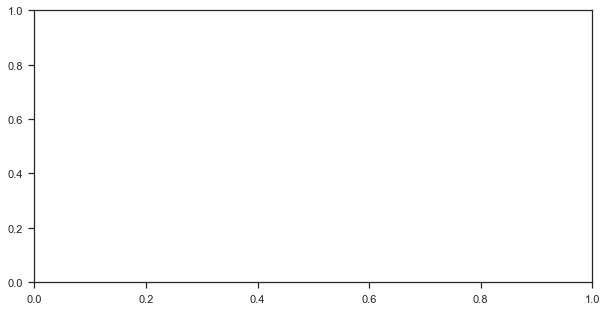

In [98]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "S Spline", 
             color = 'xkcd:forest green')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.4, 0.4)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-0.6, 0.6)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple', ax = ax2)
#ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=3, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-4, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-4.5, 35, r'L. edge', fontsize=15, rotation = 90)
ax1.text(2.5, 35, r'R. edge', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

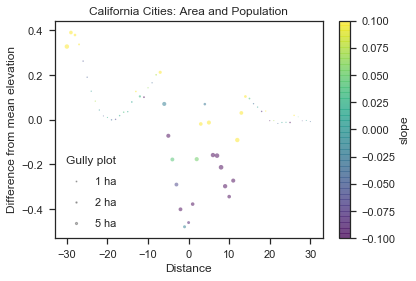

In [746]:
# Extract the data we're interested in
dfme, dist = cross_section_parameters_transpose['DFME'], cross_section_parameters_transpose['Distance']
pc, slope = cross_section_parameters_transpose['PC'], cross_section_parameters_transpose['Slope']

# Scatter the points, using size and color but no label
plt.scatter(dist, dfme, label=None,
            c=pc, cmap='viridis',
            s=slope, linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('Distance')
plt.ylabel('Difference from mean elevation')
plt.colorbar(label='slope')
plt.clim(-0.1, 0.1)

# Here we create a legend:

# we'll plot empty lists with the desired size and label
for slope in [1, 2, 5]:
    plt.scatter([], [], c='k', alpha=0.3, s=slope,
                label=str(slope) + ' ha')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Gully plot')

plt.title('California Cities: Area and Population');

In [187]:
cross_section_parameters_transpose_spline.head()

,Distance,DFMEL Spline,Elevation Spline,DFMER Spline,DFME Spline,Cumulative DFME Spline,PC Spline,A Spline,S Spline,SR Spline,d2CDFMEdx2 Spline,d2CPCdx2 Spline,dCDFMEdx Spline,dCPCdx Spline,dCSdx Spline
0,-30.0,0.475769,1.230408,-3.765404e-19,0.070007,0.070007,-0.063970,0.000056,8.756750,-2.409859e-17,-0.078615,-0.165080,0.083047,0.163970,-1.422698
1,-29.7,0.518651,1.273290,4.382538e-02,0.122105,0.122875,0.049521,0.000656,7.427976,9.495579e-01,-0.087418,-0.188767,0.069818,0.134223,-0.785570
2,-29.4,0.535821,1.290459,6.959477e-02,0.148724,0.170161,0.101806,0.000607,7.001446,1.379169e+00,-0.087551,-0.179593,0.045368,0.081740,-0.358874
3,-29.1,0.532227,1.286866,8.149547e-02,0.154692,0.211363,0.106347,0.000193,7.191391,1.449477e+00,-0.080541,-0.146210,0.014661,0.018934,-0.132832
4,-28.8,0.512820,1.267459,8.371481e-02,0.144838,0.245981,0.076611,-0.000303,7.712039,1.321126e+00,-0.067913,-0.097271,-0.017338,-0.041786,-0.097667


In [188]:
cross_section_parameters_transpose['PC'].nunique()

28

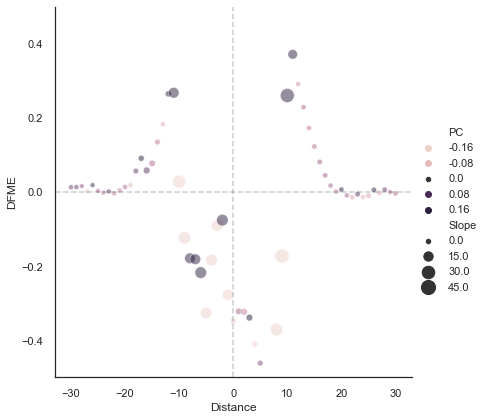

In [377]:
sns.set(style="white")

f = sns.relplot(x="Distance", y="DFME", hue="PC", size="Slope",
            sizes=(20, 200), alpha=.5, height=6, data=cross_section_parameters_transpose)

plt.axhline(y=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
f.set(ylim = (-0.5, 0.5))

## Organise one field of the dataframe into categories so that I can use the palettes in below plot. n_colors below refers to the number of categories assigned to 'name'.

In [402]:
bins = [-0.2, -0.1, -0.05, -0.01, 0, 0.01, 0.05, 0.1, 0.2]
names = ['- 0.2','- 0.1', '- 0.05', '- 0.01', '0.01', '0.05','0.1', '0.2']

cross_section_parameters_transpose['Profile Curvature'] = pd.cut(cross_section_parameters_transpose['PC'], 
                                                                 bins, labels=names)

,Distance,DFME,PC,Slope,Area,PCTL,Elevation,DFME Line,Cumulative DFME,Cumulative PC,...,dCPCdx,dCSdx,dCAdx,dPCTLdx,d2CDFMEdx2,d2CPCdx2,d2CSdx2,d2CAdx2,d2PCTLdx2,Profile Curvature
333941,-30,0.012940,0.049555,1.574076,0.002590,0.513834,1.460526,0.241562,0.012940,0.049555,...,0.007355,-0.348169,-0.002453,0.015810,0.001249,-0.020054,0.035124,0.001222,0.025692,0.05
333942,-29,0.013171,0.056909,1.225906,0.000137,0.529644,1.466324,0.247360,0.026111,0.106464,...,-0.012699,-0.313045,-0.001231,0.041502,-0.002913,-0.040002,0.121437,0.001478,-0.013834,0.1
333943,-28,0.015901,0.024156,0.947985,0.000128,0.596838,1.475754,0.256790,0.042012,0.130621,...,-0.072649,-0.105296,0.000504,-0.011858,-0.000061,0.025311,0.145076,0.000590,-0.006917,0.05
333944,-27,0.001984,-0.088388,1.015315,0.001145,0.505929,1.469620,0.250656,0.043995,0.042233,...,0.037922,-0.022894,-0.000052,0.027668,0.002985,0.061820,-0.081846,-0.000530,0.016798,- 0.1
333945,-26,0.018618,0.100000,0.902198,0.000025,0.652174,1.494690,0.275726,0.062613,0.142233,...,0.050990,-0.268988,-0.000556,0.021739,-0.005827,-0.044811,0.001402,0.000048,-0.044466,0.2
333946,-25,0.002734,0.013593,0.477338,0.000033,0.549407,1.486938,0.267975,0.065347,0.155825,...,-0.051700,-0.020090,0.000044,-0.061265,-0.000497,-0.011769,0.322225,0.000291,-0.001976,0.05
333947,-24,-0.001976,-0.003400,0.862018,0.000112,0.529644,1.488998,0.270035,0.063372,0.152425,...,0.027452,0.375462,0.000027,0.017787,0.004617,0.019476,0.184715,0.000024,0.034585,- 0.01
333948,-23,0.001496,0.068496,1.228261,0.000087,0.584980,1.498337,0.279373,0.064868,0.220921,...,-0.012749,0.349341,0.000091,0.007905,0.000954,-0.037890,-0.061098,0.000015,-0.009881,0.1
333949,-22,-0.004100,-0.028897,1.560700,0.000295,0.545455,1.497940,0.278976,0.060767,0.192024,...,-0.048328,0.253265,0.000057,-0.001976,0.004918,0.012919,-0.162448,-0.000075,0.014822,- 0.05
333950,-21,0.004073,-0.028161,1.734791,0.000202,0.581028,1.510010,0.291046,0.064841,0.163863,...,0.013090,0.024444,-0.000059,0.037549,0.002951,0.010172,0.018536,-0.000044,0.014822,- 0.05


In [860]:
filtered_pc = np.copy(cross_section_parameters_transpose['PC'].values)
filtered_pc[filtered_pc < 0] = np.nan
cross_section_parameters_transpose['PC Filtered'] = filtered_pc

In [861]:
filtered_dfme = np.copy(cross_section_parameters_transpose['DFME'].values)
filtered_dfme[filtered_dfme < 0.05] = np.nan
cross_section_parameters_transpose['DFME Filtered'] = filtered_dfme

In [862]:
filtered_slope = np.copy(cross_section_parameters_transpose['Slope'].values)
filtered_slope[filtered_slope < 10] = np.nan
cross_section_parameters_transpose['Slope Filtered'] = filtered_slope

### Three simple models are:

1. Just DFME peak near thalweg.
2. DFME peak plus positive PC.
3. DFME peak, positive PC and low slope range.

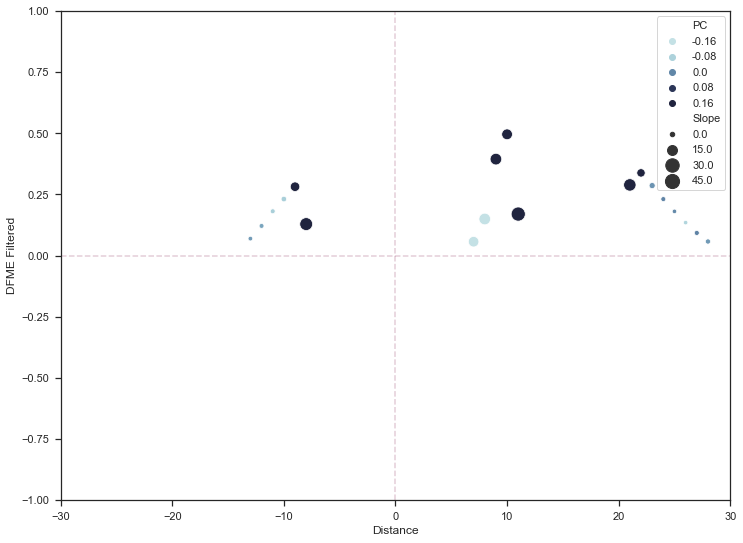

In [863]:
# Load the example planets dataset
#palette = sns.diverging_palette(10, 220, sep=1, n=8)
palette = sns.color_palette('RdBu')
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize =(12,9))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
f = sns.scatterplot(x="Distance", y="DFME Filtered",
                     hue="PC", size="Slope",
                     palette=cmap, sizes=(20, 200),
                     data=cross_section_parameters_transpose)
f.set(ylim = (-1, 1))
f.set(xlim = (-30, 30))
plt.axhline(y=0, color = 'xkcd:merlot', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:merlot', alpha = 0.2, linestyle = '--')

In [758]:
cross_section_parameters_transpose.drop(columns=['PC Filtered', 'DFME Filtered', 'Slope Filtered']);

In [ ]:
#sns.set(style="whitegrid")
sns.set(style = 'ticks')
#palette = sns.color_palette("RdBu", n_colors = 6)
palette = sns.diverging_palette(10, 220, sep=1, n=8)
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Distance", y="DFME", hue="Profile Curvature", size="Slope", palette = palette, sizes = (20, 200),
             alpha=.8, height=6, data=cross_section_parameters_transpose)
#f.set(ylim = (-0.3, 0.3))
plt.axhline(y=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')


In [106]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [107]:
np_array_to_Geotiff('xsecttest2.tif', input_geotiff, cross_section_image, drainage_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
